In [84]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [85]:
# Load the dataset
data_path = './DataExtraction/cohort_w_confounders.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset and summary statistics
data.describe()

,delirium,subject_id,hadm_id,stay_id,icu_length_of_stay_day,age,weight,duration_hours,avg_dose,max_dose,...,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score
count,4283.000000,4.283000e+03,4.283000e+03,4.283000e+03,4283.000000,4283.000000,4258.000000,4283.000000,4250.000000,4250.000000,...,4279.000000,4281.000000,4231.000000,4281.000000,4276.000000,1592.000000,2000.000000,4283.000000,4008.000000,4192.000000
mean,0.324772,1.496928e+07,2.494454e+07,3.495453e+07,4.537163,67.097362,86.646989,24.200412,2.363874,6.668408,...,0.792007,1.876664,4.110848,4.647979,0.447147,1.595477,2.477500,1.339715,3.749501,5.003101
std,0.468344,2.860678e+06,2.878006e+06,2.904983e+06,4.501094,14.652254,22.775168,37.671599,19.107131,136.385472,...,1.935911,2.949136,3.716776,4.120909,0.871250,3.075775,4.713767,2.016323,3.593470,12.172789
min,0.000000,1.000440e+07,2.000015e+07,3.000360e+07,0.541991,18.000000,20.000000,0.016667,0.300000,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.248885e+07,2.249228e+07,3.245324e+07,1.941620,58.000000,70.812500,4.016667,1.262159,1.801477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.495931e+07,2.488982e+07,3.502154e+07,3.093669,69.000000,83.800000,10.416667,1.801477,2.424381,...,0.000000,0.000000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,1.743516e+07,2.741298e+07,3.741414e+07,5.271042,78.000000,98.800000,27.158333,2.389630,3.552990,...,0.000000,4.000000,5.000000,7.000000,0.000000,0.000000,5.000000,3.000000,5.000000,3.000000
max,1.000000,1.999984e+07,2.999910e+07,3.999862e+07,50.176655,96.000000,254.000000,358.633333,1020.029007,8147.631226,...,19.000000,10.000000,15.000000,12.000000,4.000000,11.000000,16.000000,9.000000,12.000000,48.000000


In [86]:
len(data)

4283

# data preprocessing
## check messing values

In [87]:
na_df = data.isnull().sum()*100/len(data)
nadf_reset = na_df.reset_index()
nadf_reset.columns = ['Row Name', 'Missing Percentage']
nadf_reset

,Row Name,Missing Percentage
0,delirium,0.000000
1,subject_id,0.000000
2,hadm_id,0.000000
3,stay_id,0.000000
4,icu_length_of_stay_day,0.000000
5,age,0.000000
6,weight,0.583703
7,duration_hours,0.000000
8,avg_dose,0.770488
9,max_dose,0.770488


In [88]:
missing_values = data.select_dtypes(include=[np.number]).isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0].index.tolist()

In [89]:
columns_with_missing_values

['weight',
 'avg_dose',
 'max_dose',
 'avg_o2_flow',
 'avg_o2_flow_additional',
 'avg_uo_24hr',
 'avg_temperature',
 'chs_score',
 'temp_score',
 'resp_rate_score',
 'pao2_aado2_score',
 'hematocrit_score',
 'wbc_score',
 'creatinine_score',
 'uo_score',
 'bun_score',
 'sodium_score',
 'albumin_score',
 'bilirubin_score',
 'acidbase_score',
 'gcs_score']

In [90]:
# Filling missing values
# For numerical columns
data[columns_with_missing_values] = data[columns_with_missing_values].fillna(data[columns_with_missing_values].median())

## categorical values

In [91]:
# Convert 'gender' to a numeric format
data['gender'] = data['gender'].map({'M': 1, 'F': 0})

In [76]:
data['race'].value_counts()

race
WHITE                                        2737
UNKNOWN                                       578
BLACK/AFRICAN AMERICAN                        241
OTHER                                         147
UNABLE TO OBTAIN                               82
WHITE - OTHER EUROPEAN                         73
HISPANIC/LATINO - PUERTO RICAN                 57
ASIAN                                          43
ASIAN - CHINESE                                37
PATIENT DECLINED TO ANSWER                     33
WHITE - RUSSIAN                                31
HISPANIC/LATINO - DOMINICAN                    31
BLACK/CAPE VERDEAN                             26
HISPANIC OR LATINO                             26
BLACK/CARIBBEAN ISLAND                         23
PORTUGUESE                                     17
ASIAN - SOUTH EAST ASIAN                       15
BLACK/AFRICAN                                  12
WHITE - BRAZILIAN                              10
ASIAN - ASIAN INDIAN                         

In [27]:
conditions = [
    (data['race'].str.contains('WHITE', case=False)),
    (data['race'].str.contains('BLACK', case=False)),
    (data['race'].str.contains('HISPANIC', case=False)),
    (data['race'].str.contains('ASIAN', case=False)),
    (data['race'].str.contains('UNKNOWN|UNABLE|DECLINED', case=False)),
    (data['race'].str.contains('OTHER|PORTUGUESE|ALASKA|HAWAIIAN|MULTIPLE|SOUTH AMERICAN', case=False))
]
values = ['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN', 'WHITE', 'OTHER']

data['race'] = np.select(conditions, values)

In [28]:
race_df_wide = pd.get_dummies(data['race'], prefix = 'race', dtype = int)
data_race = data.drop('race', axis=1)
data_race = pd.concat((data_race, race_df_wide), axis = 1)

In [92]:
# Function to remove outliers in a dataframe
def remove_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        lower_bound = df[column].quantile(0.01)
        upper_bound = df[column].quantile(0.99)
        
        # Condition to filter out the outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the function to remove outliers
clean_data = remove_outliers(data)

In [93]:
len(clean_data)

2563

# feature selection

In [94]:
numerical_data = clean_data.select_dtypes(include=[np.number])
# Define the target variable (y) and the features (X)
X = numerical_data.drop('delirium', axis=1)
y = numerical_data['delirium']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute the correlation of each feature with the target variable
correlations = X.corrwith(y)

# Convert to a DataFrame, take the absolute values, and sort by correlation strength
correlations_df = correlations.abs().sort_values(ascending=False).reset_index()
correlations_df.columns = ['Feature', 'Absolute Correlation']

# Display the ranked features based on their absolute correlation with 'aki'
correlations_df

,Feature,Absolute Correlation
0,icu_length_of_stay_day,0.303826
1,duration_hours,0.275590
2,surgical,0.209668
3,avg_gcs,0.186099
4,avg_gcs_verbal,0.181819
5,apsiii_score,0.161705
6,hr_score,0.157593
7,creatinine_score,0.154610
8,avg_dose,0.144790
9,avg_temperature,0.140058


In [95]:
candidate_features = correlations_df[correlations_df['Absolute Correlation']>0.1]['Feature']
selected_variables = numerical_data[candidate_features]

X_train, X_test, y_train, y_test = train_test_split(selected_variables, y, test_size=0.2, random_state=42)

## backward selection

In [50]:
# Implementing a basic version of Forward Selection
# Start with no variables and add them one by one
selected_features = []
current_score, best_new_score = 0.0, 0.0

while True:
    scores_with_candidates = []
    for feature in X_train.columns:
        if feature not in selected_features:
            X_train_selected = X_train[selected_features + [feature]]
            X_test_selected = X_test[selected_features + [feature]]
            rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_classifier.fit(X_train_selected, y_train)
            y_pred = rf_classifier.predict(X_test_selected)
            score = accuracy_score(y_test, y_pred)
            scores_with_candidates.append((score, feature))
            print(f'score:{score} candidate:{feature}')
    
    scores_with_candidates.sort(reverse=True)
    best_new_score, best_candidate = scores_with_candidates[0]
    
    if best_new_score > current_score:
        selected_features.append(best_candidate)
        current_score = best_new_score
    else:
        break  # Exit loop if no improvement

selected_features

score:0.6744639376218323 candidate:icu_length_of_stay_day
score:0.682261208576998 candidate:duration_hours
score:0.7115009746588694 candidate:surgical
score:0.7115009746588694 candidate:avg_gcs
score:0.7387914230019493 candidate:avg_gcs_verbal
score:0.6842105263157895 candidate:apsiii_score
score:0.7153996101364523 candidate:hr_score
score:0.7115009746588694 candidate:creatinine_score
score:0.6413255360623782 candidate:avg_dose
score:0.6393762183235867 candidate:avg_temperature
score:0.6842105263157895 candidate:apsiii_prob
score:0.7212475633528265 candidate:bun_score
score:0.6413255360623782 candidate:avg_meanbp_min
score:0.7115009746588694 candidate:acidbase_score
score:0.6354775828460039 candidate:avg_mbp
score:0.7368421052631579 candidate:icu_length_of_stay_day
score:0.7153996101364523 candidate:duration_hours
score:0.7212475633528265 candidate:surgical
score:0.6920077972709552 candidate:avg_gcs
score:0.7017543859649122 candidate:apsiii_score
score:0.7056530214424951 candidate:hr_s

['avg_gcs_verbal']

## Top 10 feature importance using RF Regressor

In [96]:
# 5-fold cross validation
RF = RandomForestRegressor(random_state =1,criterion="absolute_error",
                           min_samples_split=10,min_samples_leaf=5,n_estimators=100)
RF.fit(X_train,y_train)
pred_values = RF.predict(X_test)
rmse = mean_squared_error(y_test,pred_values)

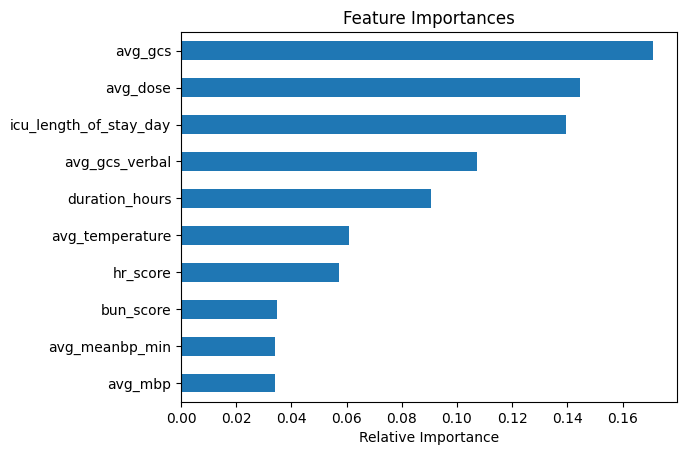

In [97]:
feat_importances = pd.Series(RF.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind = 'barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

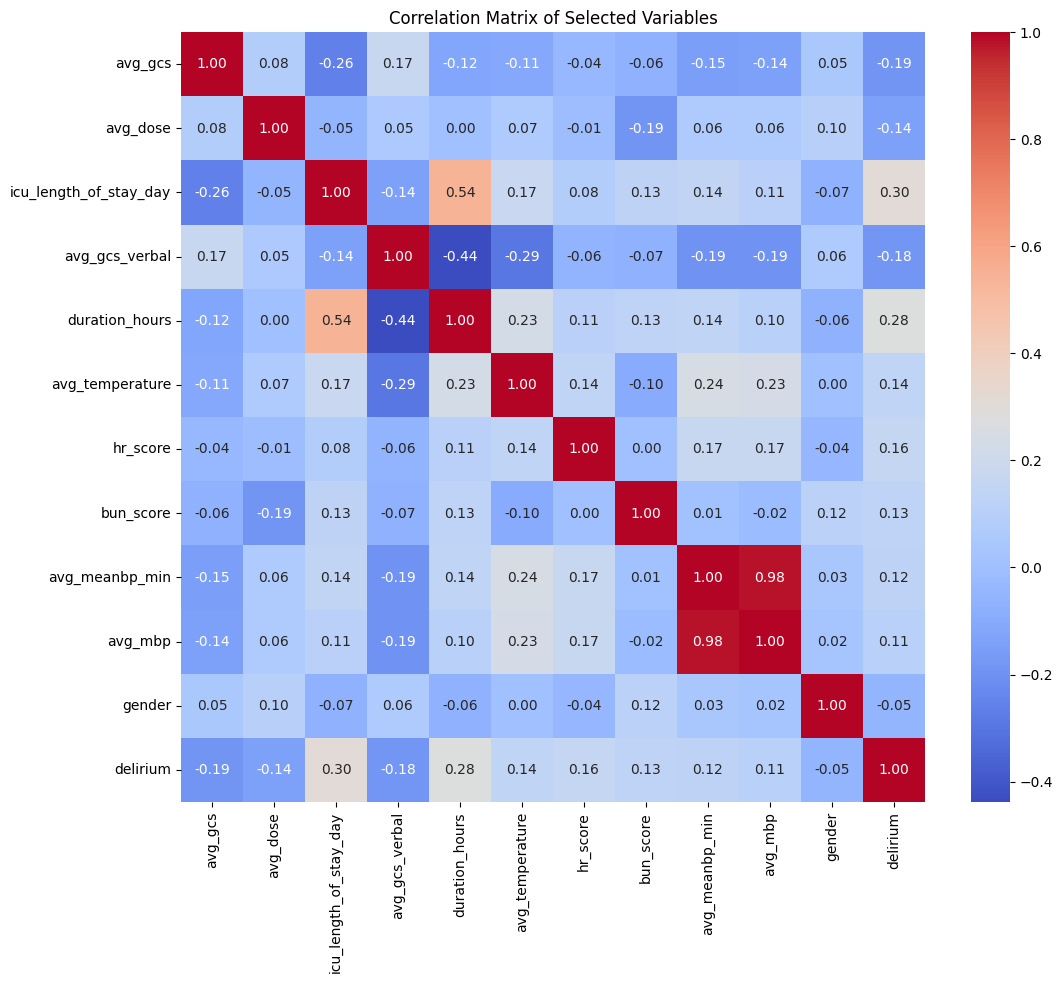

In [109]:
# Select potential confounders and the main variables
selected_columns = feat_importances.nlargest(10).index.tolist()

# Create a smaller dataframe with only selected columns
selected_columns.append('gender')
selected_columns.append('delirium')
selected_data = clean_data[selected_columns]

# Correlation matrix
correlation_matrix = selected_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Variables")
plt.show()


# Regression Model

In [110]:
# Prepare the data for modeling
X = selected_data.drop('delirium', axis=1)

y = selected_data['delirium']

# Adding constant for logistic regression with statsmodels
X = sm.add_constant(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Print the summary of the regression
result.summary()


Optimization terminated successfully.
         Current function value: 0.533349
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               delirium   No. Observations:                 2050
Model:                          Logit   Df Residuals:                     2038
Method:                           MLE   Df Model:                           11
Date:                Sat, 13 Apr 2024   Pseudo R-squ.:                  0.1327
Time:                        20:29:35   Log-Likelihood:                -1093.4
converged:                       True   LL-Null:                       -1260.6
Covariance Type:            nonrobust   LLR p-value:                 4.533e-65
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.2922      6.009     -0.714      0.475     -16.070       7.486
avg_gcs                   -0.4597      0.100     -4.591      0.000      -0.656      -0.263
avg_dose                  -0.3673      0.077     -4.763      0.000      -0.518      -0.216
icu_length_of_stay_day     0.1144      0.019      5.895      0.000       0.076       0.152
avg_gcs_verbal            -0.1133      0.052     -2.175      0.030      -0.215      -0.011
duration_hours             0.0080      0.003      3.189      0.001       0.003       0.013
avg_temperature            0.2576      0.158      1.633      0.102      -0.052       0.567
hr_score                   0.0935      0.017      5.408      0.000       0.060       0.127
bun_score                  0.0344      0.014      2.464      0.014       0.007       0.062
avg_meanbp_min             0.0692      0.038      1.808      0.071      -0.006       0.144
avg_mbp                   -0.0598      0.039     -1.528      0.126      -0.137       0.017
gender                    -0.0632      0.110     -0.573      0.567      -0.279       0.153
==========================================================================================
"""